In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import pearsonr

from armored.models import *
from armored.preprocessing import *

from sklearn.model_selection import KFold

import itertools
import re

from tqdm import tqdm

colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#8c564b",  # Brown
    "#e377c2",  # Pink
    "#7f7f7f",  # Gray
    "#bcbd22",  # Olive
    "#17becf",  # Teal
    "#9edae5",  # Light Blue
    "#c7c7c7",  # Light Gray
    "#c49c94",  # Light Red
    "#98df8a",  # Light Green
    "#f7b6d2"   # Light Pink
]

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']=75
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Arial'})

In [5]:
# import community data
df_comm = pd.read_csv("Data/arc_allcomm.csv")

# import monoculture data
df_mono = pd.read_csv("Data/arc_allmono.csv")

# define species and pH
species = ['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 
           'CC_OD', 'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD']
controls = []
metabolites = ['pH']

# concatenate all observed and all system variables 
observed = np.concatenate((np.array(species), np.array(metabolites)))
system_variables = np.concatenate((np.array(species), np.array(metabolites), np.array(controls)))
system_variables

array(['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD',
       'DF_OD', 'wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD', 'pH'],
      dtype='<U32')

# Leave One Out (LOO) Cross-Validation

In [3]:
# df for training 
all_comm_treatments = np.array([exp.split("_")[0] for exp in df_comm.Experiments.values])
unique_treatments = np.unique(all_comm_treatments) 

# loop over each community condition (test condition)
k_fold_df = pd.DataFrame()
for treatment in unique_treatments:

    # split into train and test
    test_index = np.in1d(all_comm_treatments, treatment)
    train_df = pd.concat((df_mono, df_comm.iloc[~test_index].copy()))
    test_df = df_comm.iloc[test_index].copy()

    # average replicates in train set for fitting data transform
    train_df_copy = train_df.copy()
    train_df_copy['Experiments'] = [re.split(r'(_\d+)', exp_name, maxsplit=1)[0] for exp_name in train_df_copy.Experiments.values]
    train_df_avg = []
    for exp_name, df_exp in train_df_copy.groupby("Experiments"):
        df_groups = df_exp.groupby("Time")
        df_avg = df_groups[system_variables].mean().reset_index()
        df_avg.insert(0, "Experiments", [exp_name]*df_avg.shape[0])
        train_df_avg.append(df_avg)
    train_df_avg = pd.concat(train_df_avg)

    # average replicates in test set
    df_test  = test_df.copy() 
    df_test['Experiments'] = [re.split(r'(_\d+)', exp_name, maxsplit=1)[0] for exp_name in df_test.Experiments.values]
    df_test_mean = []
    for exp_name, df_exp in df_test.groupby("Experiments"):
        df_groups = df_exp.groupby("Time")
        df_avg = df_groups[system_variables].mean().reset_index()
        df_avg.insert(0, "Experiments", [exp_name]*df_avg.shape[0])
        df_test_mean.append(df_avg)
    test_df = pd.concat(df_test_mean)
    
    # scale data 
    scaler = MinMaxScaler(observed, system_variables)
    scaler.fit(train_df_avg)
    train_df_scaled = scaler.transform(train_df.copy())
    test_df_scaled = scaler.transform(test_df.copy())

    # format data into matrix [n_samples, n_timepoints, dt+n_outputs+n_controls]
    train_data = format_data(train_df, species, metabolites, controls, observed=observed)
    train_data_scaled = format_data(train_df_scaled, species, metabolites, controls, observed=observed)
    test_data = format_data(test_df, species, metabolites, controls, observed=observed)
    test_data_scaled = format_data(test_df_scaled, species, metabolites, controls, observed=observed)

    # instantiate model
    brnn = miRNN(n_species=len(species), 
                 n_metabolites=len(metabolites), 
                 n_controls=len(controls), 
                 n_hidden=16)

    # fit model
    brnn.fit(train_data_scaled, 
             alpha_0=1., 
             evd_tol=1e-3)

    # make predictions
    predictions = scaler.inverse_transform(brnn.predict(test_data_scaled))

    # save predictions
    pred_df = pd.DataFrame()
    for (T, X, U, Y, exp_names), (_, preds, stdvs, exp_names_pred) in zip(test_data, predictions):

        # save species predictions for each experimental condition
        for i, exp_name in enumerate(exp_names):
            # init dataframe
            pred_df_exp = pd.DataFrame()

            # insert exp name
            pred_df_exp["Experiments"] = [exp_name]*len(T[i])
            pred_df_exp["Time"] = T[i]

            for j, s in enumerate(observed):
                pred_df_exp[s + " true"] = Y[i,:,j]
                pred_df_exp[s + " pred"] = preds[i,:,j]
                pred_df_exp[s + " stdv"] = stdvs[i,:,j]

            # append to test prediction dataframe
            pred_df = pd.concat((pred_df, pred_df_exp))
    k_fold_df = pd.concat((k_fold_df, pred_df))
    k_fold_df.to_csv(f"kfold/mirnn/LOO_MiRNN.csv", index=False)

Total measurements: 5987, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1080.346, Residuals: -0.00635
Loss: 1018.609, Residuals: -0.02599
Loss: 932.322, Residuals: -0.01630
Loss: 893.709, Residuals: -0.00047
Loss: 872.692, Residuals: -0.00033
Loss: 825.142, Residuals: -0.00939
Loss: 808.281, Residuals: 0.00190
Loss: 667.748, Residuals: -0.00525
Loss: 654.613, Residuals: 0.00037
Loss: 601.622, Residuals: 0.00025
Loss: 599.724, Residuals: -0.00260
Loss: 583.341, Residuals: -0.00141
Loss: 552.080, Residuals: -0.00003
Loss: 518.731, Residuals: -0.00137
Loss: 517.092, Residuals: -0.00358
Loss: 514.108, Residuals: -0.00311
Loss: 509.236, Residuals: -0.00208
Loss: 500.654, Residuals: -0.00170
Loss: 491.324, Residuals: 0.00149
Loss: 489.996, Residuals: -0.00079
Loss: 478.440, Residuals: -0.00057
Loss: 477.953, Residuals: 0.00040
Loss: 477.260, Residuals: -0.00063
Loss: 470.970, Residuals: -0.00027
Loss: 463.930, Residuals: 0.00010
Loss: 454.445, Residuals: 0.00199
Loss: 454

2024-08-19 17:09:57.718656: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5976, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1079.578, Residuals: -0.00641
Loss: 1018.815, Residuals: -0.02591
Loss: 933.384, Residuals: -0.01637
Loss: 893.928, Residuals: -0.00024
Loss: 870.985, Residuals: -0.00017
Loss: 821.373, Residuals: -0.00954
Loss: 804.120, Residuals: 0.00189
Loss: 655.511, Residuals: 0.00058
Loss: 639.907, Residuals: 0.00157
Loss: 611.084, Residuals: 0.00118
Loss: 565.981, Residuals: 0.00040
Loss: 563.686, Residuals: -0.00215
Loss: 544.458, Residuals: 0.00039
Loss: 541.732, Residuals: 0.00163
Loss: 517.905, Residuals: 0.00206
Loss: 508.159, Residuals: 0.00410
Loss: 506.027, Residuals: 0.00105
Loss: 501.999, Residuals: 0.00105
Loss: 495.560, Residuals: 0.00170
Loss: 477.100, Residuals: 0.00336
Loss: 474.248, Residuals: 0.00119
Loss: 469.224, Residuals: 0.00126
Loss: 462.962, Residuals: 0.00169
Loss: 458.609, Residuals: 0.00270
Loss: 455.283, Residuals: 0.00165
Loss: 450.443, Residuals: 0.00126
Loss: 447.073, Residu

2024-08-19 17:10:49.871335: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5970, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1083.901, Residuals: -0.00716
Loss: 1025.512, Residuals: -0.02625
Loss: 942.151, Residuals: -0.01710
Loss: 900.097, Residuals: -0.00062
Loss: 873.815, Residuals: -0.00040
Loss: 826.716, Residuals: -0.00855
Loss: 813.502, Residuals: 0.00140
Loss: 660.920, Residuals: 0.00329
Loss: 657.034, Residuals: -0.00102
Loss: 626.783, Residuals: 0.00006
Loss: 594.991, Residuals: 0.00175
Loss: 585.317, Residuals: -0.00422
Loss: 571.269, Residuals: 0.00047
Loss: 552.716, Residuals: 0.00179
Loss: 548.854, Residuals: 0.00061
Loss: 517.322, Residuals: 0.00106
Loss: 513.156, Residuals: 0.00062
Loss: 506.096, Residuals: 0.00044
Loss: 502.189, Residuals: 0.00302
Loss: 501.621, Residuals: 0.00134
Loss: 496.451, Residuals: 0.00093
Loss: 488.306, Residuals: 0.00003
Loss: 479.717, Residuals: 0.00219
Loss: 478.430, Residuals: -0.00028
Loss: 470.015, Residuals: 0.00087
Loss: 465.380, Residuals: 0.00401
Loss: 464.439, Resi

2024-08-19 17:11:39.337608: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5967, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1077.117, Residuals: -0.00667
Loss: 1017.180, Residuals: -0.02601
Loss: 932.354, Residuals: -0.01663
Loss: 891.930, Residuals: -0.00055
Loss: 867.164, Residuals: -0.00037
Loss: 816.269, Residuals: -0.00849
Loss: 801.652, Residuals: 0.00166
Loss: 659.720, Residuals: 0.00065
Loss: 647.476, Residuals: 0.00084
Loss: 623.886, Residuals: 0.00082
Loss: 588.583, Residuals: 0.00515
Loss: 581.320, Residuals: -0.00011
Loss: 567.916, Residuals: 0.00051
Loss: 554.763, Residuals: 0.00328
Loss: 553.708, Residuals: 0.00118
Loss: 519.837, Residuals: 0.00231
Loss: 518.294, Residuals: 0.00005
Loss: 515.582, Residuals: 0.00011
Loss: 510.712, Residuals: -0.00020
Loss: 506.406, Residuals: 0.00065
Loss: 505.242, Residuals: 0.00033
Loss: 495.076, Residuals: 0.00142
Loss: 486.632, Residuals: 0.00194
Loss: 483.673, Residuals: 0.00132
Loss: 482.559, Residuals: -0.00082
Loss: 480.474, Residuals: -0.00070
Loss: 476.828, Res

2024-08-19 17:12:27.039500: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5956, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1085.102, Residuals: -0.00705
Loss: 1029.213, Residuals: -0.02574
Loss: 949.004, Residuals: -0.01688
Loss: 907.048, Residuals: -0.00039
Loss: 883.466, Residuals: -0.00057
Loss: 832.044, Residuals: -0.01051
Loss: 812.767, Residuals: 0.00161
Loss: 666.173, Residuals: 0.00475
Loss: 659.076, Residuals: -0.00131
Loss: 646.264, Residuals: -0.00100
Loss: 626.836, Residuals: -0.00016
Loss: 588.146, Residuals: 0.00137
Loss: 581.345, Residuals: 0.00292
Loss: 530.138, Residuals: 0.00212
Loss: 527.957, Residuals: -0.00038
Loss: 524.595, Residuals: 0.00165
Loss: 498.192, Residuals: 0.00099
Loss: 493.974, Residuals: -0.00067
Loss: 488.546, Residuals: 0.00079
Loss: 487.963, Residuals: -0.00053
Loss: 482.518, Residuals: -0.00046
Loss: 473.396, Residuals: -0.00059
Loss: 470.655, Residuals: -0.00002
Loss: 466.660, Residuals: -0.00018
Loss: 462.140, Residuals: 0.00048
Loss: 460.348, Residuals: 0.00091
Loss: 457.98

2024-08-19 17:13:09.502656: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5958, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1103.711, Residuals: -0.00662
Loss: 1046.946, Residuals: -0.02563
Loss: 965.918, Residuals: -0.01673
Loss: 930.786, Residuals: 0.00807
Loss: 884.514, Residuals: 0.00428
Loss: 879.442, Residuals: -0.00056
Loss: 785.540, Residuals: -0.01109
Loss: 759.599, Residuals: 0.00192
Loss: 708.399, Residuals: 0.00151
Loss: 682.146, Residuals: 0.00050
Loss: 640.368, Residuals: 0.00220
Loss: 639.048, Residuals: -0.00028
Loss: 590.319, Residuals: 0.00326
Loss: 583.280, Residuals: -0.00197
Loss: 542.488, Residuals: 0.00598
Loss: 533.743, Residuals: 0.00068
Loss: 523.210, Residuals: 0.00142
Loss: 510.623, Residuals: 0.00196
Loss: 510.058, Residuals: 0.00040
Loss: 504.820, Residuals: 0.00028
Loss: 497.224, Residuals: 0.00108
Loss: 491.551, Residuals: 0.00035
Loss: 491.308, Residuals: -0.00061
Loss: 483.504, Residuals: -0.00006
Loss: 481.830, Residuals: 0.00089
Loss: 479.190, Residuals: 0.00091
Loss: 475.229, Resi

2024-08-19 17:13:51.338699: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5958, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1084.792, Residuals: -0.00758
Loss: 1030.796, Residuals: -0.02590
Loss: 952.656, Residuals: -0.01737
Loss: 909.393, Residuals: -0.00093
Loss: 885.866, Residuals: -0.00087
Loss: 827.197, Residuals: -0.01027
Loss: 807.780, Residuals: 0.00126
Loss: 660.577, Residuals: 0.00207
Loss: 659.162, Residuals: -0.00056
Loss: 646.019, Residuals: -0.00025
Loss: 621.618, Residuals: -0.00030
Loss: 586.675, Residuals: 0.00290
Loss: 581.110, Residuals: -0.00171
Loss: 571.602, Residuals: -0.00094
Loss: 553.120, Residuals: -0.00039
Loss: 521.385, Residuals: 0.00057
Loss: 502.304, Residuals: 0.00351
Loss: 498.479, Residuals: -0.00022
Loss: 493.809, Residuals: -0.00093
Loss: 485.796, Residuals: -0.00017
Loss: 485.222, Residuals: -0.00144
Loss: 480.033, Residuals: -0.00131
Loss: 476.290, Residuals: 0.00015
Loss: 471.396, Residuals: 0.00047
Loss: 468.206, Residuals: 0.00176
Loss: 467.563, Residuals: 0.00030
Loss: 466.4

2024-08-19 17:14:49.045649: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5956, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1088.207, Residuals: -0.00730
Loss: 1032.505, Residuals: -0.02594
Loss: 952.352, Residuals: -0.01712
Loss: 910.279, Residuals: -0.00077
Loss: 885.447, Residuals: -0.00083
Loss: 831.163, Residuals: -0.01102
Loss: 811.294, Residuals: 0.00132
Loss: 674.280, Residuals: -0.00488
Loss: 643.883, Residuals: 0.00316
Loss: 637.809, Residuals: 0.00107
Loss: 598.712, Residuals: 0.00218
Loss: 596.704, Residuals: -0.00072
Loss: 532.529, Residuals: -0.00029
Loss: 508.566, Residuals: 0.00193
Loss: 503.410, Residuals: 0.00216
Loss: 500.426, Residuals: -0.00081
Loss: 495.176, Residuals: -0.00065
Loss: 490.153, Residuals: 0.00075
Loss: 488.209, Residuals: 0.00200
Loss: 487.673, Residuals: 0.00046
Loss: 482.694, Residuals: 0.00090
Loss: 474.252, Residuals: 0.00128
Loss: 473.585, Residuals: 0.00020
Loss: 472.323, Residuals: 0.00019
Loss: 462.140, Residuals: 0.00064
Loss: 447.699, Residuals: 0.00032
Loss: 446.938, Re

2024-08-19 17:15:22.422000: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5959, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1086.348, Residuals: -0.00721
Loss: 1029.606, Residuals: -0.02606
Loss: 948.750, Residuals: -0.01704
Loss: 907.563, Residuals: -0.00029
Loss: 885.524, Residuals: -0.00019
Loss: 836.603, Residuals: -0.00929
Loss: 819.559, Residuals: 0.00208
Loss: 672.423, Residuals: -0.00245
Loss: 637.634, Residuals: 0.00307
Loss: 593.071, Residuals: 0.00282
Loss: 587.527, Residuals: -0.00152
Loss: 577.620, Residuals: -0.00077
Loss: 562.484, Residuals: 0.00049
Loss: 534.405, Residuals: 0.00008
Loss: 532.405, Residuals: 0.00180
Loss: 514.445, Residuals: 0.00171
Loss: 503.786, Residuals: 0.00213
Loss: 502.745, Residuals: -0.00002
Loss: 500.916, Residuals: -0.00005
Loss: 497.617, Residuals: 0.00011
Loss: 491.610, Residuals: 0.00012
Loss: 484.125, Residuals: 0.00141
Loss: 483.029, Residuals: -0.00024
Loss: 480.930, Residuals: -0.00022
Loss: 477.033, Residuals: -0.00034
Loss: 470.526, Residuals: 0.00012
Loss: 462.156,

2024-08-19 17:16:12.747069: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5958, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1085.118, Residuals: -0.00720
Loss: 1029.200, Residuals: -0.02591
Loss: 949.165, Residuals: -0.01704
Loss: 913.856, Residuals: 0.00664
Loss: 877.213, Residuals: 0.00630
Loss: 869.715, Residuals: -0.00002
Loss: 783.756, Residuals: -0.01171
Loss: 756.368, Residuals: 0.00186
Loss: 666.748, Residuals: 0.00125
Loss: 666.152, Residuals: -0.00041
Loss: 642.793, Residuals: -0.00030
Loss: 597.370, Residuals: 0.00059
Loss: 591.428, Residuals: 0.00119
Loss: 534.196, Residuals: -0.00012
Loss: 517.680, Residuals: 0.00427
Loss: 512.000, Residuals: -0.00043
Loss: 501.676, Residuals: -0.00006
Loss: 499.513, Residuals: -0.00079
Loss: 483.796, Residuals: 0.00204
Loss: 482.237, Residuals: 0.00010
Loss: 479.689, Residuals: 0.00016
Loss: 477.087, Residuals: 0.00040
Loss: 473.023, Residuals: 0.00059
Loss: 467.504, Residuals: 0.00127
Loss: 465.248, Residuals: 0.00203
Loss: 464.748, Residuals: 0.00060
Loss: 463.815, Re

2024-08-19 17:17:05.800875: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5957, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1091.567, Residuals: -0.00796
Loss: 1036.323, Residuals: -0.02651
Loss: 956.580, Residuals: -0.01777
Loss: 913.051, Residuals: -0.00095
Loss: 890.956, Residuals: -0.00070
Loss: 836.688, Residuals: -0.01264
Loss: 810.903, Residuals: 0.00134
Loss: 677.585, Residuals: -0.00149
Loss: 661.503, Residuals: 0.00020
Loss: 631.996, Residuals: 0.00000
Loss: 580.583, Residuals: 0.00104
Loss: 578.686, Residuals: -0.00184
Loss: 563.912, Residuals: -0.00084
Loss: 539.537, Residuals: -0.00058
Loss: 535.445, Residuals: 0.00154
Loss: 527.289, Residuals: 0.00131
Loss: 516.025, Residuals: 0.00160
Loss: 500.755, Residuals: 0.00127
Loss: 498.854, Residuals: 0.00033
Loss: 495.624, Residuals: 0.00047
Loss: 491.847, Residuals: 0.00138
Loss: 486.649, Residuals: 0.00184
Loss: 486.289, Residuals: 0.00052
Loss: 480.169, Residuals: 0.00158
Loss: 478.438, Residuals: 0.00031
Loss: 475.229, Residuals: 0.00041
Loss: 470.211, Res

2024-08-19 17:17:58.762999: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5962, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1082.930, Residuals: -0.00733
Loss: 1026.928, Residuals: -0.02602
Loss: 946.772, Residuals: -0.01717
Loss: 904.462, Residuals: -0.00033
Loss: 880.817, Residuals: -0.00026
Loss: 821.364, Residuals: -0.00971
Loss: 803.988, Residuals: 0.00127
Loss: 661.166, Residuals: 0.00256
Loss: 658.839, Residuals: -0.00072
Loss: 654.524, Residuals: -0.00042
Loss: 646.779, Residuals: 0.00016
Loss: 609.888, Residuals: 0.00309
Loss: 597.836, Residuals: -0.00408
Loss: 582.332, Residuals: 0.00085
Loss: 555.426, Residuals: 0.00182
Loss: 554.573, Residuals: 0.00003
Loss: 523.563, Residuals: -0.00033
Loss: 515.745, Residuals: 0.00194
Loss: 514.758, Residuals: 0.00001
Loss: 505.253, Residuals: 0.00035
Loss: 496.052, Residuals: 0.00139
Loss: 495.473, Residuals: -0.00025
Loss: 494.710, Residuals: -0.00042
Loss: 482.620, Residuals: 0.00191
Loss: 480.937, Residuals: 0.00029
Loss: 478.307, Residuals: 0.00028
Loss: 476.931, R

2024-08-19 17:18:45.057646: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5961, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1090.239, Residuals: -0.00807
Loss: 1032.744, Residuals: -0.02701
Loss: 950.185, Residuals: -0.01794
Loss: 906.309, Residuals: -0.00119
Loss: 880.963, Residuals: -0.00110
Loss: 818.695, Residuals: -0.01201
Loss: 795.459, Residuals: 0.00114
Loss: 673.602, Residuals: -0.00178
Loss: 642.293, Residuals: 0.00159
Loss: 610.274, Residuals: 0.00480
Loss: 602.547, Residuals: -0.00117
Loss: 590.600, Residuals: -0.00016
Loss: 576.983, Residuals: 0.00126
Loss: 569.140, Residuals: 0.00157
Loss: 554.181, Residuals: 0.00153
Loss: 529.530, Residuals: 0.00430
Loss: 526.558, Residuals: 0.00084
Loss: 521.008, Residuals: 0.00087
Loss: 511.080, Residuals: 0.00093
Loss: 497.849, Residuals: 0.00157
Loss: 488.089, Residuals: 0.00081
Loss: 487.248, Residuals: -0.00064
Loss: 480.791, Residuals: -0.00033
Loss: 471.371, Residuals: 0.00056
Loss: 468.217, Residuals: 0.00108
Loss: 467.615, Residuals: 0.00006
Loss: 462.234, Re

2024-08-19 17:19:48.216628: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5956, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1088.051, Residuals: -0.00777
Loss: 1030.498, Residuals: -0.02673
Loss: 947.921, Residuals: -0.01771
Loss: 905.025, Residuals: -0.00110
Loss: 882.103, Residuals: -0.00104
Loss: 834.142, Residuals: -0.00967
Loss: 816.899, Residuals: 0.00215
Loss: 654.982, Residuals: -0.00229
Loss: 594.853, Residuals: 0.00141
Loss: 591.829, Residuals: -0.00245
Loss: 586.615, Residuals: -0.00117
Loss: 577.107, Residuals: -0.00101
Loss: 561.690, Residuals: 0.00034
Loss: 558.299, Residuals: 0.00041
Loss: 528.311, Residuals: 0.00157
Loss: 525.442, Residuals: 0.00243
Loss: 520.329, Residuals: 0.00213
Loss: 517.435, Residuals: 0.00305
Loss: 515.683, Residuals: 0.00077
Loss: 502.811, Residuals: 0.00191
Loss: 496.840, Residuals: 0.00343
Loss: 496.178, Residuals: 0.00175
Loss: 490.905, Residuals: 0.00156
Loss: 482.624, Residuals: 0.00102
Loss: 473.293, Residuals: 0.00001
Loss: 470.991, Residuals: -0.00115
Loss: 468.222, Re

2024-08-19 17:20:41.351273: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5960, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1086.305, Residuals: -0.00791
Loss: 1031.660, Residuals: -0.02633
Loss: 952.631, Residuals: -0.01775
Loss: 908.833, Residuals: -0.00097
Loss: 865.208, Residuals: -0.00228
Loss: 676.752, Residuals: 0.00431
Loss: 661.583, Residuals: -0.00427
Loss: 636.864, Residuals: -0.00186
Loss: 593.642, Residuals: -0.00056
Loss: 584.897, Residuals: 0.00042
Loss: 568.834, Residuals: 0.00068
Loss: 540.162, Residuals: 0.00076
Loss: 522.424, Residuals: 0.00383
Loss: 520.100, Residuals: 0.00093
Loss: 515.564, Residuals: 0.00084
Loss: 507.649, Residuals: 0.00057
Loss: 495.602, Residuals: 0.00008
Loss: 495.531, Residuals: 0.00094
Loss: 492.762, Residuals: 0.00089
Loss: 487.471, Residuals: 0.00100
Loss: 479.095, Residuals: 0.00066
Loss: 476.546, Residuals: 0.00010
Loss: 471.858, Residuals: 0.00039
Loss: 466.011, Residuals: 0.00023
Loss: 465.826, Residuals: 0.00096
Loss: 459.575, Residuals: 0.00125
Loss: 455.410, Resid

2024-08-19 17:21:33.880117: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5959, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 1089.029, Residuals: -0.00806
Loss: 1031.880, Residuals: -0.02693
Loss: 949.627, Residuals: -0.01798
Loss: 905.622, Residuals: -0.00120
Loss: 846.516, Residuals: -0.00170
Loss: 674.222, Residuals: 0.00441
Loss: 658.903, Residuals: -0.00339
Loss: 633.284, Residuals: -0.00197
Loss: 619.881, Residuals: 0.00217
Loss: 581.011, Residuals: 0.00250
Loss: 578.345, Residuals: -0.00079
Loss: 553.903, Residuals: -0.00063
Loss: 550.221, Residuals: 0.00244
Loss: 517.195, Residuals: 0.00046
Loss: 499.777, Residuals: 0.00107
Loss: 490.535, Residuals: 0.00294
Loss: 490.116, Residuals: 0.00159
Loss: 486.361, Residuals: 0.00189
Loss: 482.113, Residuals: 0.00188
Loss: 478.798, Residuals: 0.00279
Loss: 477.253, Residuals: 0.00057
Loss: 474.367, Residuals: 0.00054
Loss: 469.403, Residuals: 0.00062
Loss: 467.889, Residuals: 0.00097
Loss: 465.638, Residuals: 0.00101
Loss: 462.571, Residuals: 0.00128
Loss: 461.417, Resi

2024-08-19 17:22:21.677702: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


Total measurements: 5081, Number of parameters: 717, Initial regularization: 1.00e+00
Loss: 722.720, Residuals: -0.01673
Loss: 647.128, Residuals: -0.00799
Loss: 632.458, Residuals: -0.00134
Loss: 609.532, Residuals: -0.00025
Loss: 565.446, Residuals: -0.00869
Loss: 536.260, Residuals: 0.00457
Loss: 415.713, Residuals: 0.00161
Loss: 413.822, Residuals: -0.00091
Loss: 410.254, Residuals: -0.00066
Loss: 404.155, Residuals: -0.00014
Loss: 393.663, Residuals: -0.00000
Loss: 378.016, Residuals: 0.00039
Loss: 373.759, Residuals: 0.00366
Loss: 368.154, Residuals: 0.00068
Loss: 363.801, Residuals: -0.00014
Loss: 356.122, Residuals: 0.00022
Loss: 343.910, Residuals: 0.00113
Loss: 341.520, Residuals: -0.00047
Loss: 326.019, Residuals: 0.00302
Loss: 322.449, Residuals: 0.00106
Loss: 316.433, Residuals: 0.00019
Loss: 312.620, Residuals: 0.00053
Loss: 310.947, Residuals: -0.00005
Loss: 308.076, Residuals: -0.00027
Loss: 303.769, Residuals: -0.00047
Loss: 297.565, Residuals: -0.00082
Loss: 290.301, 

2024-08-19 17:23:00.705641: W external/xla/xla/service/cpu/onednn_matmul.cc:172] [Perf]: MatMul reference implementation being executed


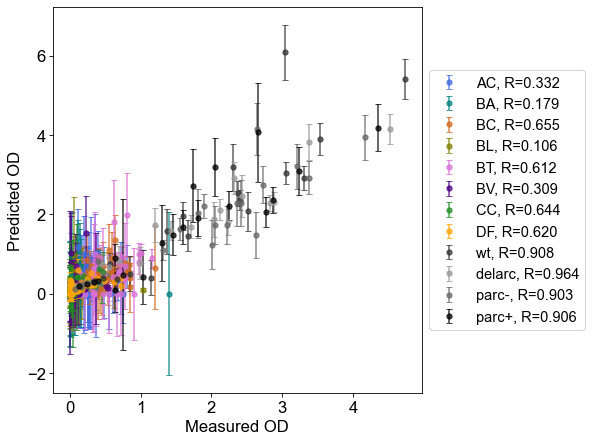

In [20]:
# import kfold results
k_fold_df = pd.read_csv(f"kfold/mirnn/LOO_MiRNN.csv")
r_vals = []
mse_vals = []
nll_vals = []

colordict = {
        'BA_OD':'teal',
        'BL_OD':'olive',
        'BC_OD':'chocolate',
        'BT_OD':'orchid',
        'BV_OD':'indigo',
        'AC_OD':'royalblue',
        'CC_OD':'forestgreen',
        'DF_OD':'orange',
        'wt_OD':(0.2,0.2,0.2),
        'delarc_OD':(0.6,0.6,0.6),
        'parc-_OD':(0.4,0.4,0.4),
        'parc+_OD':(0,0,0),
        }

plt.figure(figsize=(8, 6))
for i, obs in enumerate(species):
    
    true_vals = []
    pred_vals = []
    stdv_vals = []
    
    for exp_name, kf_df in k_fold_df.groupby("Experiments"):
        true_vals_exp = kf_df[f'{obs} true'].values
        pred_vals_exp = kf_df[f'{obs} pred'].values 
        stdv_vals_exp = kf_df[f'{obs} stdv'].values 
        
        # if species was inoculated        
        if true_vals_exp[0] > 0:
            # if not nan
            for true_val_exp, pred_val_exp, stdv_val_exp in zip(true_vals_exp[1:], pred_vals_exp[1:], stdv_vals_exp[1:]):
                if not np.isnan(true_val_exp):
                    true_vals.append(true_val_exp)
                    pred_vals.append(pred_val_exp)
                    stdv_vals.append(stdv_val_exp)
    
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    stdv_vals = np.array(stdv_vals)
    
    # compute stats
    R = pearsonr(true_vals, pred_vals)[0]
    r_vals.append(R)
    mse_vals.append(np.mean((true_vals-pred_vals)**2))
    
    # plot
    plt.errorbar(true_vals, pred_vals, yerr=stdv_vals, 
                 fmt='.', capsize=3, markersize=10, c=colordict[obs], alpha=.75, 
                 label = f'{obs.split("_")[0]}, R={R:.3f}')
plt.legend(loc='center left', bbox_to_anchor=(1, .5), fontsize=14)
plt.xlabel("Measured OD", fontsize=16)
plt.ylabel("Predicted OD", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(f"Figures/mirnn/mirnn_species_LOO.svg")
plt.show()

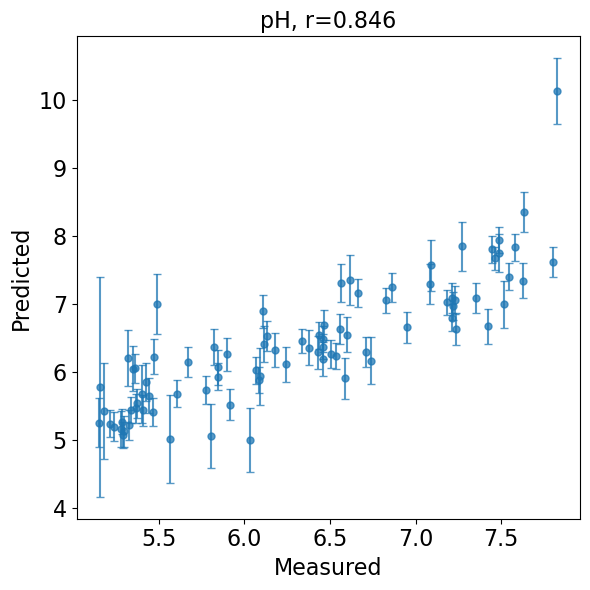

In [12]:
# import kfold results
r_vals = []
mse_vals = []
nll_vals = []


for i, obs in enumerate(metabolites):
    plt.figure(figsize=(6, 6))
    
    true_vals = []
    pred_vals = []
    stdv_vals = []
    
    for exp_name, kf_df in k_fold_df.groupby("Experiments"):
        true_vals_exp = kf_df[f'{obs} true'].values
        pred_vals_exp = kf_df[f'{obs} pred'].values 
        stdv_vals_exp = kf_df[f'{obs} stdv'].values 
        
        # if not nan
        for true_val_exp, pred_val_exp, stdv_val_exp in zip(true_vals_exp[1:], pred_vals_exp[1:], stdv_vals_exp[1:]):
            if not np.isnan(true_val_exp):
                true_vals.append(true_val_exp)
                pred_vals.append(pred_val_exp)
                stdv_vals.append(stdv_val_exp)
    
    true_vals = np.array(true_vals)
    pred_vals = np.array(pred_vals)
    stdv_vals = np.array(stdv_vals)
    
    # compute stats
    R = linregress(true_vals, pred_vals).rvalue
    r_vals.append(R)
    mse_vals.append(np.mean((true_vals-pred_vals)**2))
    
    # plot
    plt.errorbar(true_vals, pred_vals, yerr=stdv_vals, 
                 fmt='.', capsize=3, markersize=10, c=colors[i], alpha=.75)
    plt.title(f'{obs}, r={R:.3f}', fontsize=16)
    plt.xlabel("Measured", fontsize=16)
    plt.ylabel("Predicted", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(f"Figures/mirnn/mirnn_{obs}_LOO.pdf")
    plt.show()